#### Section 1: Importing Necessary Libraries

In [11]:
### Basic Imports
import numpy as np
import pandas as pd
import random
import toml
import os
import logging
import math
import json
from datetime import datetime
import seaborn as sns
### Matplot Lib Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Parallel Processing Libraries
from functools import partial
import time
from concurrent.futures import ProcessPoolExecutor, as_completed,ThreadPoolExecutor
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import concurrent.futures

### Scipy Imports
from scipy.spatial import distance
from shapely.geometry import Point, MultiPoint
from shapely.ops import cascaded_union
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import cdist
### Other Imports
import warnings
from copy import deepcopy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Any
from abc import ABC, abstractmethod
from matplotlib.colors import LinearSegmentedColormap
from typing import List, Dict, Tuple, Optional
import itertools
import copy

#### Section 1.1: Basic Utility Functions

In [12]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def create_distance_matrix(locations):
    n = len(locations)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = euclidean_distance(locations[i], locations[j])
    return matrix

def create_charging_distance_matrix(locations, charging_stations):
    matrix = np.zeros((len(locations), len(charging_stations)))
    for i, loc in enumerate(locations):
        for j, station in enumerate(charging_stations):
            matrix[i][j] = euclidean_distance(loc, station)
    return matrix

In [13]:
class EVRPSolution:
    def __init__(self):
        self.routes = []
        self.vehicle_types = []
        self.route_loads = []
        self.route_distances = []
        self.route_energies = []
        self.delivery_times = []
        self.computation_time = 0.0

    def add_route(self, route, vehicle_type, load):
        self.routes.append(route)
        self.vehicle_types.append(vehicle_type)
        self.route_loads.append(load)

In [14]:
class EVConfig:
    def __init__(self):
        self.categories = {
            'small': {
                'battery_capacity': 35,
                'base_weight': 1500,
                'load_capacity': 500
            },
            'medium': {
                'battery_capacity': 40,
                'base_weight': 1800,
                'load_capacity': 600
            },
            'large': {
                'battery_capacity': 45,
                'base_weight': 2000,
                'load_capacity': 700
            },
            'xlarge': {
                'battery_capacity': 50,
                'base_weight': 2200,
                'load_capacity': 800
            }
        }
        self.initial_charging = 100
        self.speed = 25
        self.energy_consumption_rate = 0.15
        self.weight_factor = 0.05
        self.battery_safety_margin = 40

In [15]:
class EVRPInstance:
    def __init__(self, instance_id, depot_location, customer_locations, 
                 charging_stations, customer_items_weights, charging_rate):
        self.instance_id = instance_id
        self.depot_location = depot_location
        self.customer_locations = customer_locations
        self.charging_stations = charging_stations
        self.customer_items_weights = customer_items_weights
        self.charging_rate = charging_rate
        
        # Create distance matrices
        self.distance_matrix = self._create_distance_matrix()
        self.charging_distance_matrix = self._create_charging_distance_matrix()

    def _create_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_distance_matrix(locations)

    def _create_charging_distance_matrix(self):
        locations = [self.depot_location] + self.customer_locations
        return create_charging_distance_matrix(locations, self.charging_stations)

In [16]:
class GreedyEVRPSolver:
    def __init__(self, instance: EVRPInstance):
        self.instance = instance
        self.ev_config = EVConfig()
        self.best_solution = EVRPSolution()
        self.served_customers = set()
        self.fleet = {
            'xlarge': 0,
            'large': 0,
            'medium': 0,
            'small': 0
        }
        
    def calculate_min_vehicles_needed(self) -> Dict[str, int]:
        total_demand = sum(self.instance.customer_items_weights)
        unit_fleet_capacity = sum(
            self.ev_config.categories[v_type]['load_capacity']
            for v_type in ['xlarge', 'large', 'medium', 'small']
        )
        min_vehicles = math.ceil(total_demand / unit_fleet_capacity)
        return {
            'xlarge': min_vehicles,
            'large': min_vehicles,
            'medium': min_vehicles,
            'small': min_vehicles
        }

    def increase_fleet_binary(self, current_fleet: Dict[str, int]) -> Dict[str, int]:
        """Increase fleet following binary pattern"""
        # Get base value (minimum number of vehicles)
        base = min(current_fleet.values())
        
        # Convert current configuration to binary
        binary = ''
        for v_type in ['xlarge', 'large', 'medium', 'small']:
            binary += '1' if current_fleet[v_type] > base else '0'
        
        # Increment binary pattern
        current_value = int(binary, 2)
        next_value = current_value + 1
        
        # If we've used all patterns (1111), increment base
        if next_value > 15:  # 15 is 1111 in binary
            base += 1
            next_value = 0
        
        # Convert back to binary
        new_binary = format(next_value, '04b')
        
        # Create new fleet configuration
        new_fleet = {}
        for i, v_type in enumerate(['xlarge', 'large', 'medium', 'small']):
            new_fleet[v_type] = base + (1 if new_binary[i] == '1' else 0)
        
        return new_fleet
    
    def calculate_proportional_loads(self, fleet: Dict[str, int], total_demand: float) -> Dict[str, float]:
        """Calculate proportional load distribution based on vehicle capacities"""
        proportional_loads = {}
        total_capacity = 0
        
        # Calculate total capacity considering vehicle type capacities
        for v_type, count in fleet.items():
            if count > 0:
                capacity = self.ev_config.categories[v_type]['load_capacity']
                total_capacity += capacity * count

        # Calculate percentages and target loads
        for v_type, count in fleet.items():
            if count > 0:
                # Calculate percentage based on vehicle type capacity
                capacity = self.ev_config.categories[v_type]['load_capacity']
                percentage = capacity / total_capacity
                # Calculate target load
                target_load = total_demand * percentage
                # Ensure target load doesn't exceed vehicle capacity
                proportional_loads[v_type] = min(target_load, capacity)
            else:
                proportional_loads[v_type] = 0

        print(proportional_loads)

        return proportional_loads

    def find_best_next_customer(self, current_pos: int, unserved_customers: List[int]) -> Optional[int]:
        best_customer = None
        min_distance = float('inf')
        
        for customer_idx in unserved_customers:
            if customer_idx in self.served_customers:
                continue
                
            customer_id = customer_idx + 1
            distance_to_customer = self.calculate_distance(current_pos, customer_id)
            
            # Simply choose the nearest customer
            if distance_to_customer < min_distance:
                min_distance = distance_to_customer
                best_customer = customer_idx
                
        return best_customer

    def create_route(self, unserved_customers: List[int], vehicle_type: str, 
                target_load: float) -> Tuple[List[int], float]:
        """
        Create a route allowing only one customer to exceed the proportional load target.
        
        Args:
            unserved_customers: List of customer indices not yet served
            vehicle_type: Type of vehicle ('small', 'medium', 'large', 'xlarge')
            target_load: Target proportional load for this vehicle type
            
        Returns:
            Tuple containing:
            - List[int]: Route (sequence of customer indices, starting and ending with depot)
            - float: Total load for the route
        """
        route = [0]  # Start from depot
        current_load = 0
        allowed_excess = True  # Flag to track if we can still allow one customer to exceed
        vehicle_capacity = self.ev_config.categories[vehicle_type]['load_capacity']
        
        while unserved_customers:
            next_customer = self.find_best_next_customer(route[-1], unserved_customers)
            
            if next_customer is None:
                break
                
            customer_demand = self.instance.customer_items_weights[next_customer]
            is_last_customer = len(unserved_customers) == 1
            
            # Check if adding this customer would exceed vehicle capacity
            if current_load + customer_demand > vehicle_capacity:
                break
                
            # Check if adding this customer would exceed target load
            exceeds_target = current_load + customer_demand > target_load
            
            if exceeds_target:
                if allowed_excess and not is_last_customer:
                    # Allow this customer but mark that we can't exceed again
                    allowed_excess = False
                else:
                    # We've already used our one excess or it's the last customer
                    break
                    
            customer_id = next_customer + 1
            route.append(customer_id)
            current_load += customer_demand
            
            self.served_customers.add(next_customer)
            unserved_customers.remove(next_customer)
            
        route.append(0)  # Return to depot
        return route, current_load

    def solve(self) -> EVRPSolution:
        """Main solving procedure with distance-based customer selection"""
        total_demand = sum(self.instance.customer_items_weights)
        # Start with minimum vehicles
        self.fleet = self.calculate_min_vehicles_needed()
        max_attempts = 16  # Maximum number of fleet configurations to try
        attempt = 0
        
        while attempt < max_attempts:
            print(f"\nAttempt {attempt + 1}: Trying fleet configuration: {self.fleet}")
            solution = EVRPSolution()
            solution.computation_time = 0.0
            self.served_customers.clear()
            
            proportional_loads = self.calculate_proportional_loads(self.fleet, total_demand)
            print(f"\nProportional target loads:")
            for v_type in ['small', 'medium', 'large', 'xlarge']:
                print(f"{v_type}: {proportional_loads[v_type]:.2f} kg (max capacity: {self.ev_config.categories[v_type]['load_capacity']} kg)")
            
            # Create routes for each vehicle type
            for v_type in ['small', 'medium', 'large', 'xlarge']:
                num_vehicles = self.fleet[v_type]
                
                print(f"\nAssigning customers to {v_type} vehicles")
                print(f"Target load per vehicle: {proportional_loads[v_type]:.2f} kg")
                
                for vehicle_num in range(num_vehicles):
                    if len(self.served_customers) == len(self.instance.customer_locations):
                        break
                        
                    unserved = [i for i in range(len(self.instance.customer_locations)) 
                            if i not in self.served_customers]
                    
                    route, load = self.create_route(unserved, v_type, 
                                                proportional_loads[v_type])  # Now using proportional load
                    
                    if route and len(route) > 2:  # If route contains any customers
                        route_with_charging = self.insert_charging_stations(route, load, v_type)
                        distance, energy, time, battery_levels = self.calculate_route_metrics(
                            route_with_charging, load, v_type)
                        
                        solution.add_route(route_with_charging, v_type, load)
                        solution.route_distances.append(distance)
                        solution.route_energies.append(energy)
                        solution.delivery_times.append(time)
                        
                        print(f"Created route for {v_type} vehicle {vehicle_num + 1}:")
                        print(f"Load: {load:.2f} kg")
                        print(f"Customers: {[c for c in route if c > 0]}")
            
            unserved_count = len(self.instance.customer_locations) - len(self.served_customers)
            if unserved_count == 0:
                print("\nAll customers served successfully!")
                return solution
            else:
                print(f"\nWarning: {unserved_count} customers remain unserved")
                print("Increasing fleet size...")
                self.fleet = self.increase_fleet_binary(self.fleet)
                attempt += 1
        
        print("\nNo feasible solution found within maximum attempts")
        return EVRPSolution()  # Return empty solution instead of None
    
    def insert_charging_stations(self, route: List[int], load: float, 
                               vehicle_type: str) -> List[int]:
        if len(route) <= 2:  # Only depot-customer-depot
            return route
            
        new_route = [0]  # Start at depot
        current_battery = self.ev_config.initial_charging
        current_load = load
        
        for i in range(1, len(route)):
            from_loc = route[i-1]
            to_loc = route[i]
            
            # Calculate energy needed for next leg
            distance = self.calculate_distance(from_loc, to_loc)
            energy_needed = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            # Check if charging is needed
            if current_battery - energy_needed < self.ev_config.battery_safety_margin:
                # Find nearest charging station
                charging_station = self.find_nearest_charging_station(new_route[-1])
                new_route.append(charging_station)
                current_battery = self.ev_config.initial_charging
                
                # Recalculate energy needed from charging station
                distance = self.calculate_distance(charging_station, to_loc)
                energy_needed = self.calculate_energy_consumption(
                    distance, current_load, vehicle_type)
            
            new_route.append(to_loc)
            current_battery -= energy_needed
            
            # Update load after delivery (if it's a customer)
            if to_loc > 0:
                current_load -= self.instance.customer_items_weights[to_loc-1]
        
        return new_route

    def calculate_route_metrics(self, route: List[int], load: float,
                              vehicle_type: str) -> Tuple[float, float, float, List[Tuple[int, float]]]:
        """Calculate distance, energy consumption, delivery time and battery levels"""
        total_distance = 0
        total_energy = 0
        total_time = 0
        current_load = load
        current_battery = self.ev_config.initial_charging
        battery_levels = [(route[0], current_battery)]
        
        for i in range(len(route) - 1):
            from_loc = route[i]
            to_loc = route[i + 1]
            
            distance = self.calculate_distance(from_loc, to_loc)
            energy = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            total_distance += distance
            total_energy += energy
            total_time += distance / self.ev_config.speed
            
            current_battery -= energy
            
            if from_loc < 0:  # At charging station
                charging_time = (self.ev_config.categories[vehicle_type]['battery_capacity'] / 
                               self.instance.charging_rate)
                total_time += charging_time
                current_battery = self.ev_config.initial_charging
            
            if to_loc > 0:  # Delivering to customer
                current_load -= self.instance.customer_items_weights[to_loc-1]
            
            battery_levels.append((to_loc, current_battery))
        
        return total_distance, total_energy, total_time, battery_levels

    def calculate_energy_consumption(self, distance: float, load: float, 
                                  vehicle_type: str) -> float:
        """Calculate energy consumption for a given distance and load"""
        vehicle_specs = self.ev_config.categories[vehicle_type]
        total_weight = vehicle_specs['base_weight'] + load
        return distance * (self.ev_config.energy_consumption_rate + 
                         (total_weight * self.ev_config.weight_factor/1000))

    def calculate_distance(self, from_location: int, to_location: int) -> float:
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        elif from_location < 0:  # From charging station
            charging_station_index = -from_location - 1
            return self.instance.charging_distance_matrix[to_location][charging_station_index]
        else:  # To charging station
            charging_station_index = -to_location - 1
            return self.instance.charging_distance_matrix[from_location][charging_station_index]

    def find_nearest_charging_station(self, location: int) -> int:
        """Find the nearest charging station to a given location"""
        if location < 0:
            return location  # Already at a charging station
            
        distances = self.instance.charging_distance_matrix[location]
        nearest_index = np.argmin(distances)
        return -(nearest_index + 1)  # Convert to charging station index

In [17]:
def validate_input_data(instance):
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
def read_toml_input(file_path):
    try:
        data = toml.load(file_path)
        instance = {
            'instance_id': os.path.basename(file_path).split('.')[0],
            'depot_location': data['depot_location'],
            'customer_locations': data['customer_locations'],
            'charging_stations': data['charging_stations'],
            'customer_items_weights': data['customer_items_weights'],
            'charging_rate': data['charging_rate'],
            'vehicle_speed': data.get('vehicle_speed', 25),  # default if not specified
            'ev_parameters': data.get('ev_parameters', None)
        }
        
        # Validate data
        validate_input_data(instance)
        return instance
        
    except Exception as e:
        raise Exception(f"Error reading TOML file: {str(e)}")

In [18]:
class SimulatedAnnealingEVRPSolver:
    def __init__(self, instance: EVRPInstance, initial_solution: EVRPSolution):
        self.instance = instance
        self.ev_config = EVConfig()
        self.initial_solution = initial_solution
        self.best_solution = None
        self.current_solution = None
        
        # SA Parameters
        self.INITIAL_TEMP = 10.0
        self.FINAL_TEMP = 5.0
        self.COOLING_RATE = 0.99
        self.ITERATIONS_PER_TEMP = 5
        self.TARGET_OCCUPATION = 0.85  # 85% capacity as target
        
        # Analysis metrics
        self.iteration_metrics = []

    # Add this function to plot convergence
    def plot_convergence(self,iteration_metrics):
        """
        Plot the convergence of the SA algorithm showing temperature, 
        current cost, and best cost over iterations.
        """
        import matplotlib.pyplot as plt

        iterations = [m['iteration'] for m in iteration_metrics]
        temperatures = [m['temperature'] for m in iteration_metrics]
        current_costs = [m['current_cost'] for m in iteration_metrics]
        best_costs = [m['best_cost'] for m in iteration_metrics]

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])
        fig.suptitle('Simulated Annealing Convergence', fontsize=16)

        # Plot temperature
        ax1.plot(iterations, temperatures, 'r-', label='Temperature')
        ax1.set_ylabel('Temperature')
        ax1.set_xlabel('Iteration')
        ax1.grid(True)
        ax1.legend()

        # Plot costs
        ax2.plot(iterations, current_costs, 'b-', alpha=0.5, label='Current Solution Cost')
        ax2.plot(iterations, best_costs, 'g-', label='Best Solution Cost')
        ax2.set_ylabel('Cost (Max Delivery Time)')
        ax2.set_xlabel('Iteration')
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()

        # Also print some summary statistics
        print("\nConvergence Summary:")
        print(f"Initial Cost: {best_costs[0]:.2f}")
        print(f"Final Cost: {best_costs[-1]:.2f}")
        print(f"Improvement: {((best_costs[0] - best_costs[-1])/best_costs[0])*100:.2f}%")
        
        # Calculate where the best solution was found
        best_iteration = iterations[best_costs.index(min(best_costs))]
        print(f"Best solution found at iteration: {best_iteration}")
        
        # Calculate acceptance rate
        improvements = sum(1 for i in range(1, len(current_costs)) 
                        if current_costs[i] < current_costs[i-1])
        acceptance_rate = improvements / len(current_costs) * 100
        print(f"Solution Improvement Rate: {acceptance_rate:.2f}%")
        
    def remove_charging_stations(self, solution: EVRPSolution) -> EVRPSolution:
        """Remove charging stations from routes while maintaining customer sequence"""
        new_solution = EVRPSolution()
        new_solution.computation_time = solution.computation_time
        
        for route_idx, route in enumerate(solution.routes):
            # Keep only depot (0) and customers (positive numbers)
            new_route = [loc for loc in route if loc >= 0]
            new_solution.add_route(new_route, 
                                 solution.vehicle_types[route_idx],
                                 solution.route_loads[route_idx])
            
        return new_solution
    
    def find_over_occupied_routes(self, solution: EVRPSolution) -> List[dict]:
        """Identify routes that exceed target occupation"""
        over_occupied = []
        
        for route_idx, route in enumerate(solution.routes):
            vehicle_type = solution.vehicle_types[route_idx]
            customers = [c for c in route if c > 0]
            current_load = sum(self.instance.customer_items_weights[c-1] for c in customers)
            capacity = self.ev_config.categories[vehicle_type]['load_capacity']
            
            occupation_ratio = current_load / capacity
            if occupation_ratio > self.TARGET_OCCUPATION:
                over_occupied.append({
                    'route_idx': route_idx,
                    'ratio': occupation_ratio,
                    'excess': current_load - (self.TARGET_OCCUPATION * capacity),
                    'current_load': current_load,
                    'capacity': capacity
                })
        
        return sorted(over_occupied, key=lambda x: x['ratio'], reverse=True)
    
    
    
    def calculate_distance(self, from_location: int, to_location: int) -> float:
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        return 0  # Placeholder for charging stations
    
    def find_best_insertion(self, customer: int, candidate_route: List[int],
                          vehicle_type: str, load: float) -> Tuple[int, float, float]:
        """Find best insertion position for a customer in a route"""
        best_position = -1
        best_time = float('inf')
        best_distance = float('inf')
        customer_demand = self.instance.customer_items_weights[customer-1]
        
        # Check if adding customer exceeds vehicle capacity
        if load + customer_demand > self.ev_config.categories[vehicle_type]['load_capacity']:
            return best_position, best_time, best_distance
        
        for i in range(1, len(candidate_route)):
            new_route = candidate_route[:i] + [customer] + candidate_route[i:]
            distance, time = self.calculate_route_metrics(new_route, 
                                                        load + customer_demand,
                                                        vehicle_type)
            
            if time < best_time:
                best_time = time
                best_distance = distance
                best_position = i
                
        return best_position, best_time, best_distance
    
    
    def generate_neighbor(self, solution: EVRPSolution) -> Optional[EVRPSolution]:
        """
        Generate neighbor by:
        1. Identifying the route with maximum delivery time
        2. Selecting a customer from this route
        3. Finding the best feasible route to reassign this customer
        
        Returns:
            Optional[EVRPSolution]: New solution with customer moved to best position,
                                or None if no feasible move found
        """
        # Create a copy of the current solution
        new_solution = deepcopy(solution)
        
        # Calculate delivery time for each route
        route_metrics = []
        for idx, route in enumerate(new_solution.routes):
            vehicle_type = new_solution.vehicle_types[idx]
            load = new_solution.route_loads[idx]
            distance, energy, time, _ = self.calculate_route_metrics(route, load, vehicle_type)
            
            # Store metrics and customer count
            customer_count = len([loc for loc in route if loc > 0])
            route_metrics.append({
                'index': idx,
                'time': time,
                'load': load,
                'customer_count': customer_count,
                'vehicle_type': vehicle_type
            })
        
        # Find route with maximum delivery time
        longest_route = max(route_metrics, key=lambda x: x['time'])
        if longest_route['customer_count'] <= 1:
            return None  # Can't remove from route with 0 or 1 customer
        
        # Get customers from longest route
        source_route_idx = longest_route['index']
        source_customers = [loc for loc in new_solution.routes[source_route_idx] if loc > 0]
        
        # Randomly select a customer to move
        customer_to_move = random.choice(source_customers)
        customer_weight = self.instance.customer_items_weights[customer_to_move-1]
        
        # Find best route and position to insert the customer
        best_metrics = {
            'route_idx': None,
            'position': None,
            'new_max_time': float('inf')
        }
        
        # Try inserting into each other route
        for target_idx, route in enumerate(new_solution.routes):
            if target_idx == source_route_idx:
                continue
                
            vehicle_type = new_solution.vehicle_types[target_idx]
            current_load = new_solution.route_loads[target_idx]
            
            # Check capacity constraint
            if current_load + customer_weight > self.ev_config.categories[vehicle_type]['load_capacity']:
                continue
            
            # Try each insertion position
            for pos in range(1, len(route)):
                # Create temporary route with customer inserted
                temp_route = route[:pos] + [customer_to_move] + route[pos:]
                
                # Calculate new delivery time for target route
                _, _, target_time, _ = self.calculate_route_metrics(
                    temp_route,
                    current_load + customer_weight,
                    vehicle_type
                )
                
                # Calculate new delivery time for source route after removal
                new_source_route = [loc for loc in new_solution.routes[source_route_idx] 
                                if loc != customer_to_move]
                _, _, source_time, _ = self.calculate_route_metrics(
                    new_source_route,
                    longest_route['load'] - customer_weight,
                    longest_route['vehicle_type']
                )
                
                # Calculate new maximum time across all routes
                temp_max_time = max(
                    max(target_time, source_time),
                    max(route_metrics[i]['time'] for i in range(len(route_metrics))
                        if i != target_idx and i != source_route_idx)
                )
                
                # Update best position if this gives better max time
                if temp_max_time < best_metrics['new_max_time']:
                    best_metrics.update({
                        'route_idx': target_idx,
                        'position': pos,
                        'new_max_time': temp_max_time
                    })
        
        # If no feasible move found, return None
        if best_metrics['route_idx'] is None:
            return None
        
        # Apply the best move found
        target_idx = best_metrics['route_idx']
        
        # Remove customer from source route
        new_solution.routes[source_route_idx] = [
            loc for loc in new_solution.routes[source_route_idx] 
            if loc != customer_to_move
        ]
        new_solution.route_loads[source_route_idx] -= customer_weight
        
        # Insert customer into target route at best position
        target_route = new_solution.routes[target_idx]
        new_solution.routes[target_idx] = (
            target_route[:best_metrics['position']] +
            [customer_to_move] +
            target_route[best_metrics['position']:]
        )
        new_solution.route_loads[target_idx] += customer_weight
        
        return new_solution

    def calculate_max_delivery_time(self, solution: EVRPSolution) -> float:
        """Calculate maximum delivery time across all routes"""
        max_time = 0
        
        for idx, route in enumerate(solution.routes):
            vehicle_type = solution.vehicle_types[idx]
            load = solution.route_loads[idx]
            _, _, time, _ = self.calculate_route_metrics(route, load, vehicle_type)
            max_time = max(max_time, time)
            
        return max_time
    def solve(self) -> EVRPSolution:
        """Main SA algorithm with improved metrics collection"""
        print("\nStarting Simulated Annealing optimization...")
        start_time = time.time()
        
        # Initialize
        self.current_solution = self.remove_charging_stations(self.initial_solution)
        self.best_solution = deepcopy(self.current_solution)
        current_cost = self.calculate_max_delivery_time(self.current_solution)
        best_cost = current_cost
        
        temperature = self.INITIAL_TEMP
        iteration = 0
        self.iteration_metrics = []  # Reset metrics
        
        print(f"\nInitial solution max delivery time: {current_cost:.2f} hours")
        print("\nOptimizing routes...")
        
        # Record initial state
        self.iteration_metrics.append({
            'iteration': iteration,
            'temperature': temperature,
            'current_cost': current_cost,
            'best_cost': best_cost,
        })
        
        while temperature > self.FINAL_TEMP:
            for _ in range(self.ITERATIONS_PER_TEMP):
                iteration += 1
                
                # Generate neighbor
                neighbor = self.generate_neighbor(self.current_solution)
                if neighbor is None:
                    continue
                    
                neighbor_cost = self.calculate_max_delivery_time(neighbor)
                delta_cost = neighbor_cost - current_cost

                # Accept or reject
                accepted = False
                if (delta_cost < 0 or 
                    random.random() < math.exp(-delta_cost / temperature)):
                    self.current_solution = neighbor
                    current_cost = neighbor_cost
                    accepted = True
                    
                    if current_cost < best_cost:
                        self.best_solution = deepcopy(neighbor)
                        best_cost = current_cost
                        print(f"New best solution found! Max delivery time: {best_cost:.2f} hours")
                
                # Record metrics
                self.iteration_metrics.append({
                    'iteration': iteration,
                    'temperature': temperature,
                    'current_cost': current_cost,
                    'best_cost': best_cost,
                    'accepted': accepted,
                    'delta_cost': delta_cost
                })
            
            # Cool down
            temperature *= self.COOLING_RATE
        
        # Insert charging stations into best solution
        print("\nInserting charging stations into final solution...")
        final_solution = self.insert_charging_stations(self.best_solution)
        final_solution.computation_time = time.time() - start_time
        
        print(f"\nSA optimization completed in {final_solution.computation_time:.2f} seconds")
        print(f"Final max delivery time: {best_cost:.2f} hours")
        
        # Plot convergence
        self.plot_convergence(self.iteration_metrics)
        
        return final_solution
    
    def insert_charging_stations(self, solution: EVRPSolution) -> EVRPSolution:
        """Insert charging stations into routes using greedy algorithm's logic"""
        solver = GreedyEVRPSolver(self.instance)
        final_solution = EVRPSolution()
        
        for route_idx, route in enumerate(solution.routes):
            vehicle_type = solution.vehicle_types[route_idx]
            load = solution.route_loads[route_idx]
            
            route_with_charging = solver.insert_charging_stations(route, load, vehicle_type)
            distance, energy, time, _ = solver.calculate_route_metrics(
                route_with_charging, load, vehicle_type)
            
            final_solution.add_route(route_with_charging, vehicle_type, load)
            final_solution.route_distances.append(distance)
            final_solution.route_energies.append(energy)
            final_solution.delivery_times.append(time)
        
        return final_solution
    
    def calculate_route_metrics(self, route: List[int], load: float,
                              vehicle_type: str) -> Tuple[float, float, float, List[Tuple[int, float]]]:
        """Calculate distance, energy consumption, delivery time and battery levels"""
        total_distance = 0
        total_energy = 0
        total_time = 0
        current_load = load
        current_battery = self.ev_config.initial_charging
        battery_levels = [(route[0], current_battery)]
        
        for i in range(len(route) - 1):
            from_loc = route[i]
            to_loc = route[i + 1]
            
            distance = self.calculate_distance(from_loc, to_loc)
            energy = self.calculate_energy_consumption(
                distance, current_load, vehicle_type)
            
            total_distance += distance
            total_energy += energy
            total_time += distance / self.ev_config.speed
            
            current_battery -= energy
            
            if from_loc < 0:  # At charging station
                charging_time = (self.ev_config.categories[vehicle_type]['battery_capacity'] / 
                               self.instance.charging_rate)
                total_time += charging_time
                current_battery = self.ev_config.initial_charging
            
            if to_loc > 0:  # Delivering to customer
                current_load -= self.instance.customer_items_weights[to_loc-1]
            
            battery_levels.append((to_loc, current_battery))
        
        return total_distance, total_energy, total_time, battery_levels

    def calculate_energy_consumption(self, distance: float, load: float, 
                                  vehicle_type: str) -> float:
        """Calculate energy consumption for a given distance and load"""
        vehicle_specs = self.ev_config.categories[vehicle_type]
        total_weight = vehicle_specs['base_weight'] + load
        return distance * (self.ev_config.energy_consumption_rate + 
                         (total_weight * self.ev_config.weight_factor/1000))

    def calculate_distance(self, from_location: int, to_location: int) -> float:
        """Calculate distance between two locations"""
        if from_location >= 0 and to_location >= 0:
            return self.instance.distance_matrix[from_location][to_location]
        elif from_location < 0:  # From charging station
            charging_station_index = -from_location - 1
            return self.instance.charging_distance_matrix[to_location][charging_station_index]
        else:  # To charging station
            charging_station_index = -to_location - 1
            return self.instance.charging_distance_matrix[from_location][charging_station_index]

    def find_nearest_charging_station(self, location: int) -> int:
        """Find the nearest charging station to a given location"""
        if location < 0:
            return location  # Already at a charging station
            
        distances = self.instance.charging_distance_matrix[location]
        nearest_index = np.argmin(distances)
        return -(nearest_index + 1)  # Convert to charging station index

In [19]:
def validate_input_data(instance):
    # Check if all required fields exist
    required_fields = ['instance_id', 'depot_location', 'customer_locations', 
                      'charging_stations', 'customer_items_weights', 'charging_rate']
    
    for field in required_fields:
        if field not in instance:
            raise ValueError(f"Missing required field: {field}")
def read_toml_input(file_path):
    try:
        data = toml.load(file_path)
        instance = {
            'instance_id': os.path.basename(file_path).split('.')[0],
            'depot_location': data['depot_location'],
            'customer_locations': data['customer_locations'],
            'charging_stations': data['charging_stations'],
            'customer_items_weights': data['customer_items_weights'],
            'charging_rate': data['charging_rate'],
            'vehicle_speed': data.get('vehicle_speed', 25),  # default if not specified
            'ev_parameters': data.get('ev_parameters', None)
        }
        
        # Validate data
        validate_input_data(instance)
        return instance
        
    except Exception as e:
        raise Exception(f"Error reading TOML file: {str(e)}")

Loading data from /Users/chanakyavasantha/Comsets/test_cases/customers_40/c40_7.toml...

Problem Instance Details:
Instance ID: c40_7
Number of Customers: 40
Number of Charging Stations: 10
Total Delivery Weight: 3075 kg
Charging Rate: 22 kWh/h

Initializing Greedy EVRP Solver...
Solving problem using Greedy approach...

Attempt 1: Trying fleet configuration: {'xlarge': 2, 'large': 2, 'medium': 2, 'small': 2}
{'xlarge': 473.0769230769231, 'large': 413.9423076923077, 'medium': 354.8076923076923, 'small': 295.67307692307696}

Proportional target loads:
small: 295.67 kg (max capacity: 500 kg)
medium: 354.81 kg (max capacity: 600 kg)
large: 413.94 kg (max capacity: 700 kg)
xlarge: 473.08 kg (max capacity: 800 kg)

Assigning customers to small vehicles
Target load per vehicle: 295.67 kg
Created route for small vehicle 1:
Load: 345.00 kg
Customers: [13, 12, 6, 35, 11]
Created route for small vehicle 2:
Load: 340.00 kg
Customers: [10, 24, 8, 22]

Assigning customers to medium vehicles
Target 

New best solution found! Max delivery time: 6.25 hours
New best solution found! Max delivery time: 6.24 hours
New best solution found! Max delivery time: 6.22 hours
New best solution found! Max delivery time: 6.21 hours
New best solution found! Max delivery time: 6.18 hours
New best solution found! Max delivery time: 6.14 hours
New best solution found! Max delivery time: 6.13 hours
New best solution found! Max delivery time: 6.12 hours
New best solution found! Max delivery time: 5.98 hours
New best solution found! Max delivery time: 5.97 hours
New best solution found! Max delivery time: 5.93 hours
New best solution found! Max delivery time: 5.90 hours
New best solution found! Max delivery time: 5.88 hours
New best solution found! Max delivery time: 5.82 hours

Inserting charging stations into final solution...

SA optimization completed in 7.62 seconds
Final max delivery time: 5.82 hours


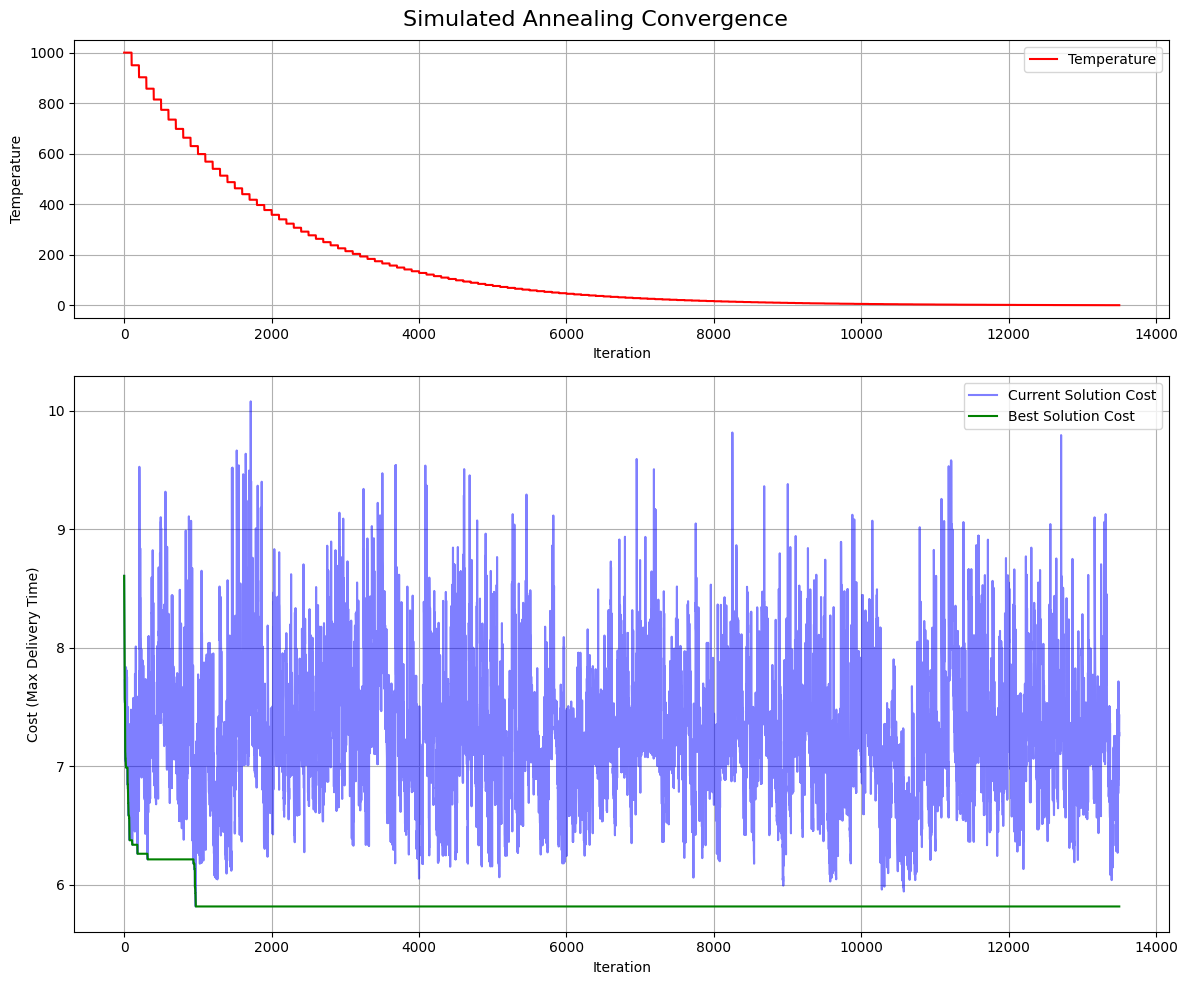


Convergence Summary:
Initial Cost: 8.61
Final Cost: 5.82
Improvement: 32.42%
Best solution found at iteration: 970
Solution Improvement Rate: 66.77%

=== Solution Comparison ===
Greedy Solution:
Total routes (vehicles used): 8

Route 1:
Vehicle Type: SMALL
Load: 345.00 kg
Sequence with battery levels:
D (100.0%) → C13 (97.1%) → C12 (93.5%) → C6 (89.6%) → C35 (86.0%) → C11 (83.7%) → D (75.7%)
Distance: 104.75 km
Energy: 24.34 kWh
Time: 4.19 hours
Customers served: 5
Charging stops: 0

Route 2:
Vehicle Type: SMALL
Load: 340.00 kg
Sequence with battery levels:
D (100.0%) → C10 (95.7%) → C24 (91.7%) → C8 (88.5%) → C22 (85.8%) → D (75.7%)
Distance: 105.08 km
Energy: 24.34 kWh
Time: 4.20 hours
Customers served: 4
Charging stops: 0

Route 3:
Vehicle Type: MEDIUM
Load: 430.00 kg
Sequence with battery levels:
D (100.0%) → C16 (95.2%) → C3 (92.0%) → C19 (88.9%) → C20 (85.5%) → C30 (82.2%) → D (68.8%)
Distance: 126.07 km
Energy: 31.19 kWh
Time: 5.04 hours
Customers served: 5
Charging stops: 0

R

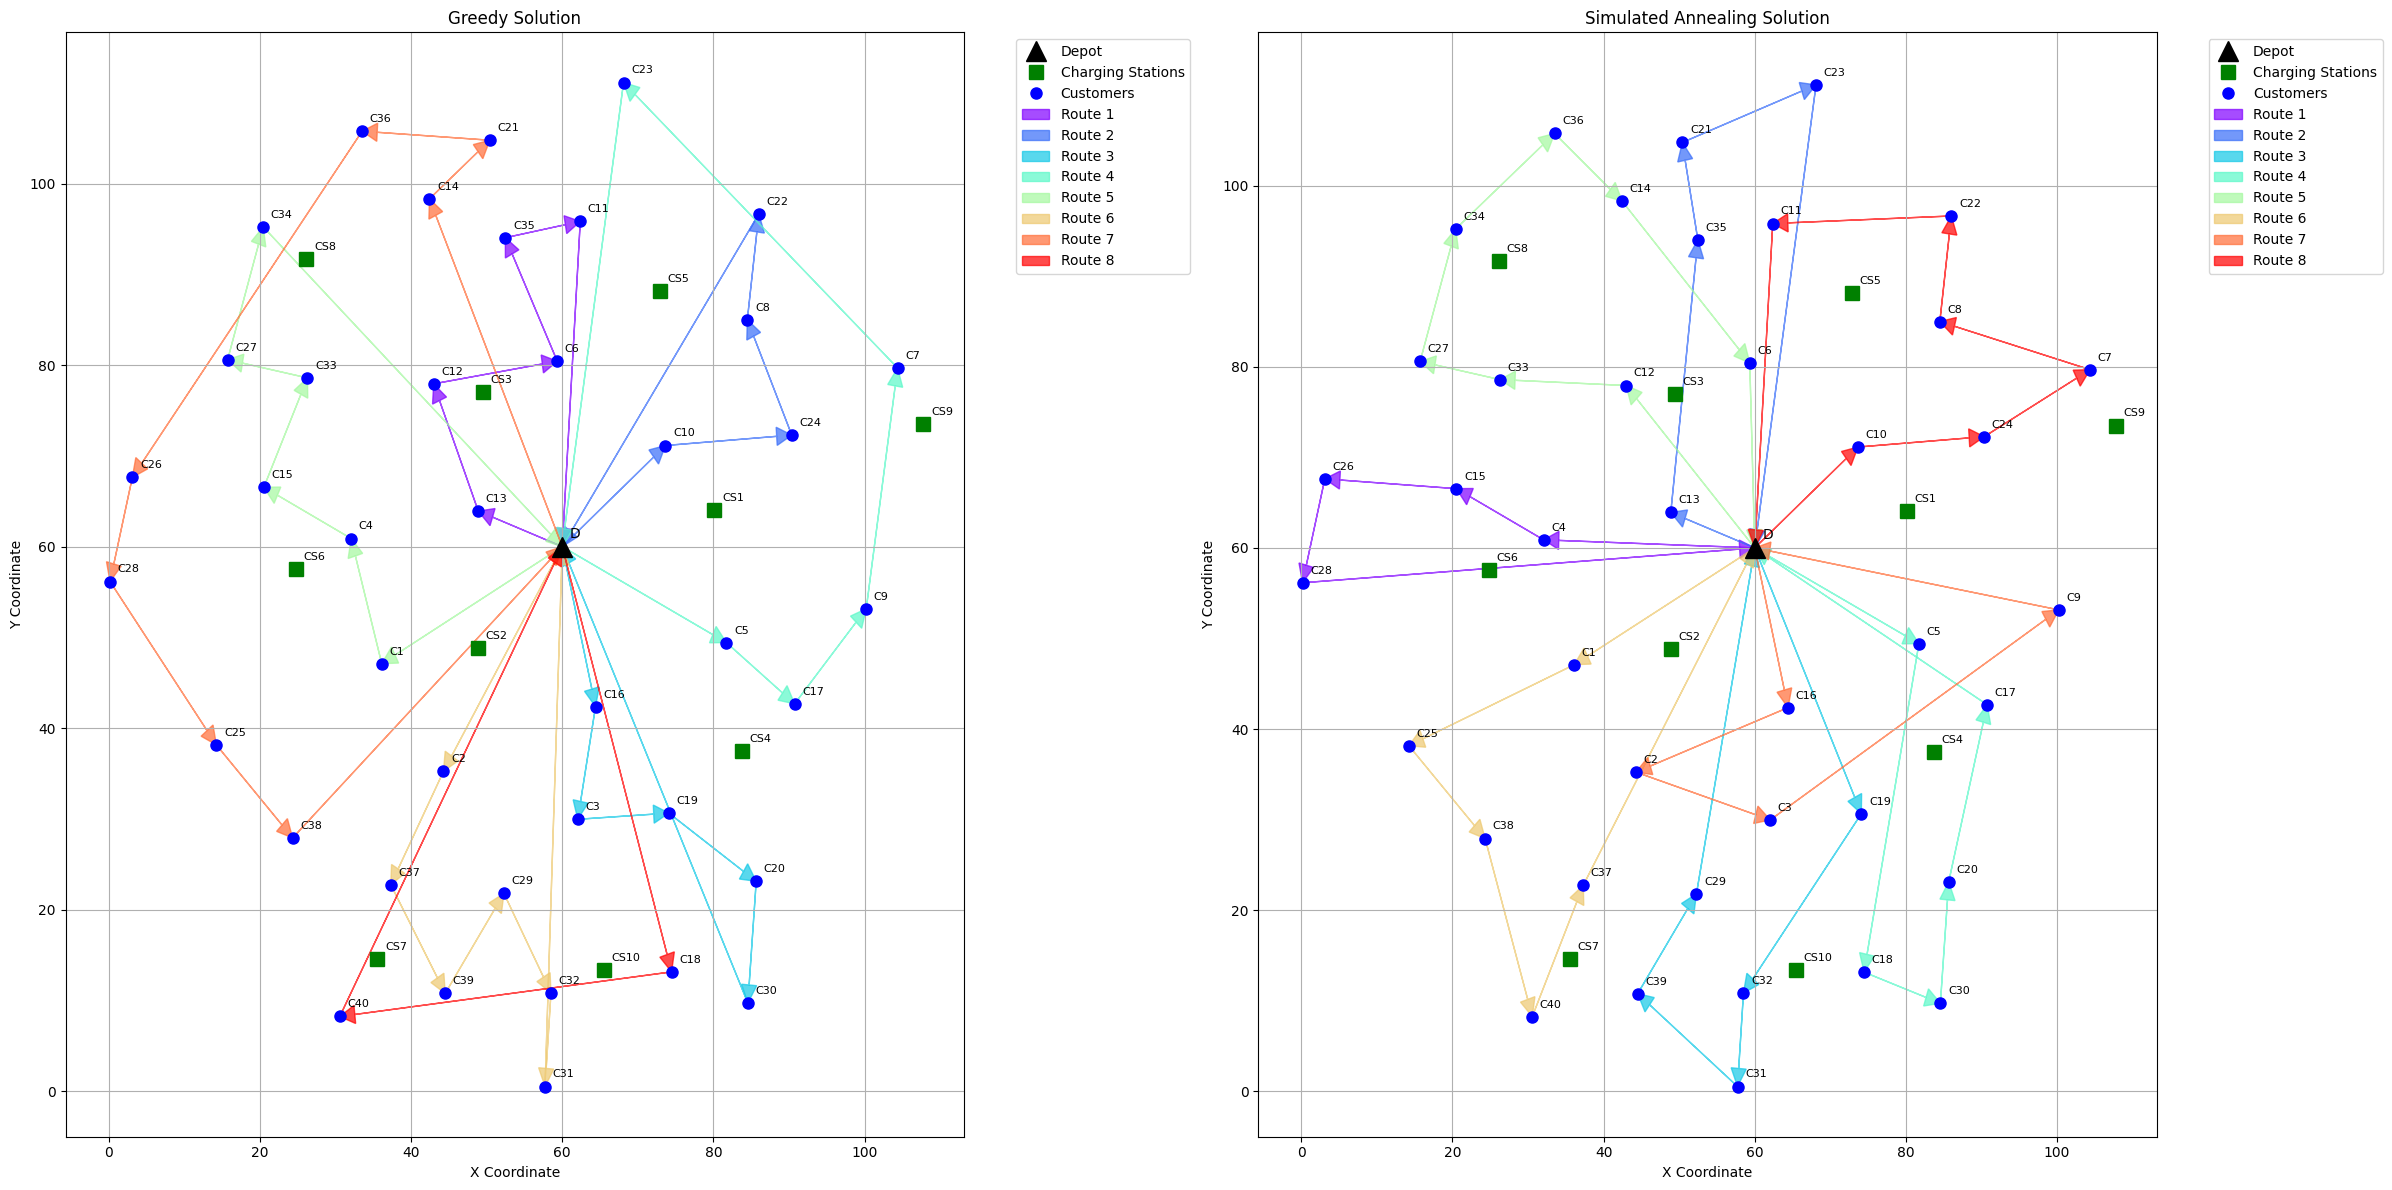

In [20]:
def run_ev_routing(toml_file_path, use_sa=True):
    print(f"Loading data from {toml_file_path}...")
    
    # Read and validate input
    instance_data = read_toml_input(toml_file_path)
    
    # Create problem instance
    instance = EVRPInstance(
        instance_id=instance_data['instance_id'],
        depot_location=instance_data['depot_location'],
        customer_locations=instance_data['customer_locations'],
        charging_stations=instance_data['charging_stations'],
        customer_items_weights=instance_data['customer_items_weights'],
        charging_rate=instance_data['charging_rate']
    )
    
    # Print problem details
    print("\nProblem Instance Details:")
    print(f"Instance ID: {instance_data['instance_id']}")
    print(f"Number of Customers: {len(instance_data['customer_locations'])}")
    print(f"Number of Charging Stations: {len(instance_data['charging_stations'])}")
    print(f"Total Delivery Weight: {sum(instance_data['customer_items_weights'])} kg")
    print(f"Charging Rate: {instance_data['charging_rate']} kWh/h")
    
    # First solve with Greedy
    print("\nInitializing Greedy EVRP Solver...")
    greedy_solver = GreedyEVRPSolver(instance)
    print("Solving problem using Greedy approach...")
    greedy_solution = greedy_solver.solve()
    
    # If SA is requested, use Greedy solution as initial solution
    if use_sa:
        print("\nInitializing Simulated Annealing EVRP Solver...")
        sa_solver = SimulatedAnnealingEVRPSolver(instance, greedy_solution)
        
        # Set SA parameters directly after initialization
        sa_solver.INITIAL_TEMP = 1000.0
        sa_solver.FINAL_TEMP = 1.0
        sa_solver.COOLING_RATE = 0.95
        sa_solver.ITERATIONS_PER_TEMP = 100
        
        print("Solving problem using Simulated Annealing...")
        sa_solution = sa_solver.solve()
        
        # Print comparison of solutions
        print("\n=== Solution Comparison ===")
        print("Greedy Solution:")
        print_solution_details(greedy_solver, greedy_solution)
        print("\nSimulated Annealing Solution:")
        print_solution_details(sa_solver, sa_solution)
        
        # Plot both solutions
        plot_solutions(instance, greedy_solution, sa_solution)
        
        return greedy_solver, greedy_solution, sa_solver, sa_solution
    else:
        # Print only greedy solution
        print("\n=== Greedy Solution Details ===")
        print_solution_details(greedy_solver, greedy_solution)
        plot_solutions(instance, greedy_solution)
        
        return greedy_solver, greedy_solution


def print_solution_details(solver, solution):
    print(f"Total routes (vehicles used): {len(solution.routes)}")
    
    vehicle_counts = {}
    total_distance = 0
    total_energy = 0
    total_customers = 0
    
    for i, (route, v_type, load) in enumerate(zip(
            solution.routes, solution.vehicle_types, solution.route_loads)):
        
        # Calculate metrics including battery levels
        distance, energy, time, battery_levels = solver.calculate_route_metrics(
            route, load, v_type)
        
        # Update vehicle counts
        vehicle_counts[v_type] = vehicle_counts.get(v_type, 0) + 1
        
        print(f"\nRoute {i+1}:")
        print(f"Vehicle Type: {v_type.upper()}")
        print(f"Load: {load:.2f} kg")
        
        # Print route sequence with battery levels
        print("Sequence with battery levels:")
        print_route_sequence(battery_levels)
        
        print(f"Distance: {distance:.2f} km")
        print(f"Energy: {energy:.2f} kWh")
        print(f"Time: {time:.2f} hours")
        
        num_customers = sum(1 for loc in route if loc > 0)
        num_charges = sum(1 for loc in route if loc < 0)
        print(f"Customers served: {num_customers}")
        print(f"Charging stops: {num_charges}")
        
        total_distance += distance
        total_energy += energy
        total_customers += num_customers
    
    print_summary_statistics(vehicle_counts, total_distance, total_energy, 
                           total_customers, solution.computation_time)

def print_route_sequence(battery_levels):
    for stop_idx, (loc, battery) in enumerate(battery_levels):
        if loc == 0:
            location_str = "D"  # Depot
        elif loc > 0:
            location_str = f"C{loc}"  # Customer
        else:
            location_str = f"CS{-loc}"  # Charging Station
        
        arrow = " → " if stop_idx < len(battery_levels) - 1 else ""
        print(f"{location_str} ({battery:.1f}%){arrow}", end="")
    print()  # New line after sequence

def print_summary_statistics(vehicle_counts, total_distance, total_energy, 
                           total_customers, computation_time):
    print("\n=== Overall Statistics ===")
    print("Vehicle Distribution:")
    for v_type, count in vehicle_counts.items():
        print(f"{v_type.upper()}: {count} vehicles")
    
    if total_distance > 0 and total_customers > 0:
        print(f"\nTotal distance: {total_distance:.2f} km")
        print(f"Total energy consumption: {total_energy:.2f} kWh")
        print(f"Average energy per km: {total_energy/total_distance:.3f} kWh/km")
        print(f"Total customers served: {total_customers}")
        print(f"Average distance per customer: {total_distance/total_customers:.2f} km")
    else:
        print("\nNo feasible routes were found!")
        print("Possible reasons:")
        print("- Vehicle capacity constraints")
        print("- Battery range limitations")
        print("- Distance/energy constraints")
        print("Consider adjusting vehicle parameters or problem constraints")
    
    print(f"Computation time: {computation_time:.2f} seconds")

def plot_solutions(instance, greedy_solution, sa_solution=None):
    if sa_solution:
        # Create two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
        
        # Plot Greedy solution
        plot_single_solution(instance, greedy_solution, ax1, "Greedy Solution")
        
        # Plot SA solution
        plot_single_solution(instance, sa_solution, ax2, "Simulated Annealing Solution")
        
    else:
        # Single plot for Greedy solution
        plt.figure(figsize=(12, 12))
        plot_single_solution(instance, greedy_solution, plt.gca(), "Electric Vehicle Routes")
    
    plt.tight_layout()
    plt.show()

def plot_single_solution(instance, solution, ax, title):
    """Plot a single solution"""
    # Plot depot
    ax.plot(instance.depot_location[0], instance.depot_location[1], 
            'k^', markersize=15, label='Depot')
    ax.text(instance.depot_location[0] + 1, instance.depot_location[1] + 1, 
            'D', fontsize=10)
    
    # Plot charging stations
    charging_stations = np.array(instance.charging_stations)
    ax.plot(charging_stations[:, 0], charging_stations[:, 1], 
            'gs', markersize=10, label='Charging Stations')
    for i, (x, y) in enumerate(charging_stations):
        ax.text(x + 1, y + 1, f'CS{i+1}', fontsize=8)
    
    # Plot customers
    customers = np.array(instance.customer_locations)
    ax.plot(customers[:, 0], customers[:, 1], 
            'bo', markersize=8, label='Customers')
    for i, (x, y) in enumerate(customers):
        ax.text(x + 1, y + 1, f'C{i+1}', fontsize=8)
    
    # Plot routes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(solution.routes)))
    all_locations = [instance.depot_location] + instance.customer_locations
    
    for route_idx, (route, color) in enumerate(zip(solution.routes, colors)):
        for i in range(len(route) - 1):
            # Get coordinates
            if route[i] >= 0:
                start = all_locations[route[i]]
            else:
                start = instance.charging_stations[-route[i]-1]
                
            if route[i+1] >= 0:
                end = all_locations[route[i+1]]
            else:
                end = instance.charging_stations[-route[i+1]-1]
            
            # Draw arrow
            ax.arrow(start[0], start[1], 
                    end[0] - start[0], end[1] - start[1],
                    head_width=2, head_length=2, fc=color, ec=color,
                    length_includes_head=True, alpha=0.7,
                    label=f'Route {route_idx+1}' if i == 0 else "")
    
    ax.set_title(title)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        

if __name__ == "__main__":
    # Example usage
    toml_path = "/Users/chanakyavasantha/Comsets/test_cases/customers_40/c40_7.toml"
    # Run both Greedy and SA
    greedy_solver, greedy_solution, sa_solver, sa_solution = run_ev_routing(
        toml_path, use_sa=True)

In [ ]:
d -> c1 -> c2 -> c3 -> c4 -> c5 -> c6 -> d
d -> a1 -> a2 -> a3 -> a4 -> d
-----
d -> c1 -> c2 -> c3 -> a4 -> d
d -> a1 -> a2 -> a3 -> c4 -> c5 -> c6 -> d